# Video Transformers

By Alberto Valdés

**Mail 1:** anvaldes@uc.cl

**Mail 2:** alberto.valdes.gonzalez.96@gmail.com

This notebook was executed in Google Colab using a A100-GPU.

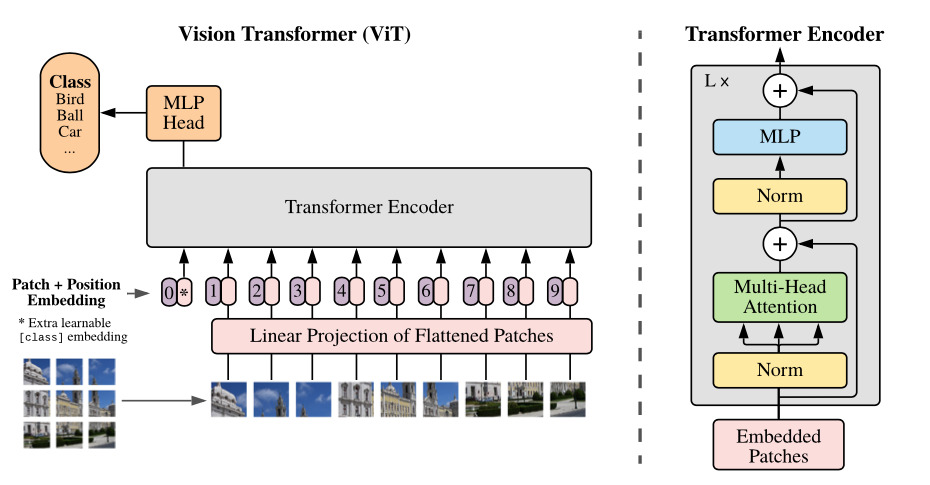

### Start of execution

In [1]:
import time

In [2]:
start = time.time()

### 1. Setting the environment

In [3]:
!pip install -q datasets==2.20.0

In [4]:
!pip install -q bitsandbytes==0.43.1

### 2. Import Libraries

In [5]:
import torch
import random
import numpy as np
from transformers import Trainer
from datasets import load_dataset
from transformers import TrainingArguments
from transformers import ViTImageProcessor
from PIL import ImageDraw, ImageFont, Image
from transformers import ViTForImageClassification

### 3. Functions

In [6]:
def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(350, 350)):

    w, h = size
    labels = ds['train'].features['labels'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 24)

    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = ds['train'].filter(lambda ex: ex['labels'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255), font=font)

    return grid

In [7]:
def process_example(example):
    inputs = processor(example['image'], return_tensors='pt')
    inputs['labels'] = example['labels']
    return inputs

In [8]:
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = processor([x for x in example_batch['image']], return_tensors = 'pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs

In [9]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

### 4. Load datasets

In [10]:
ds = load_dataset('beans')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


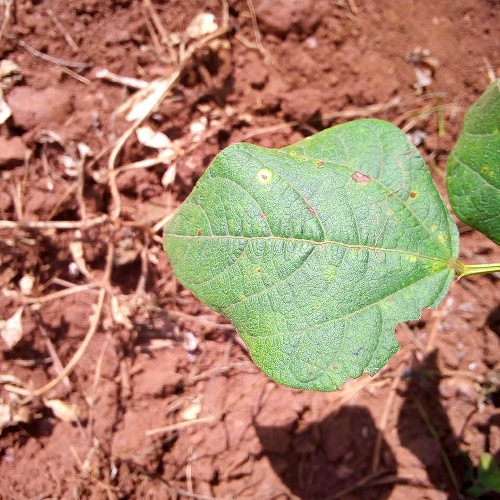

In [11]:
ds['train'][400]['image']

In [12]:
labels = ds['train'].features['labels'].names

In [13]:
labels

['angular_leaf_spot', 'bean_rust', 'healthy']

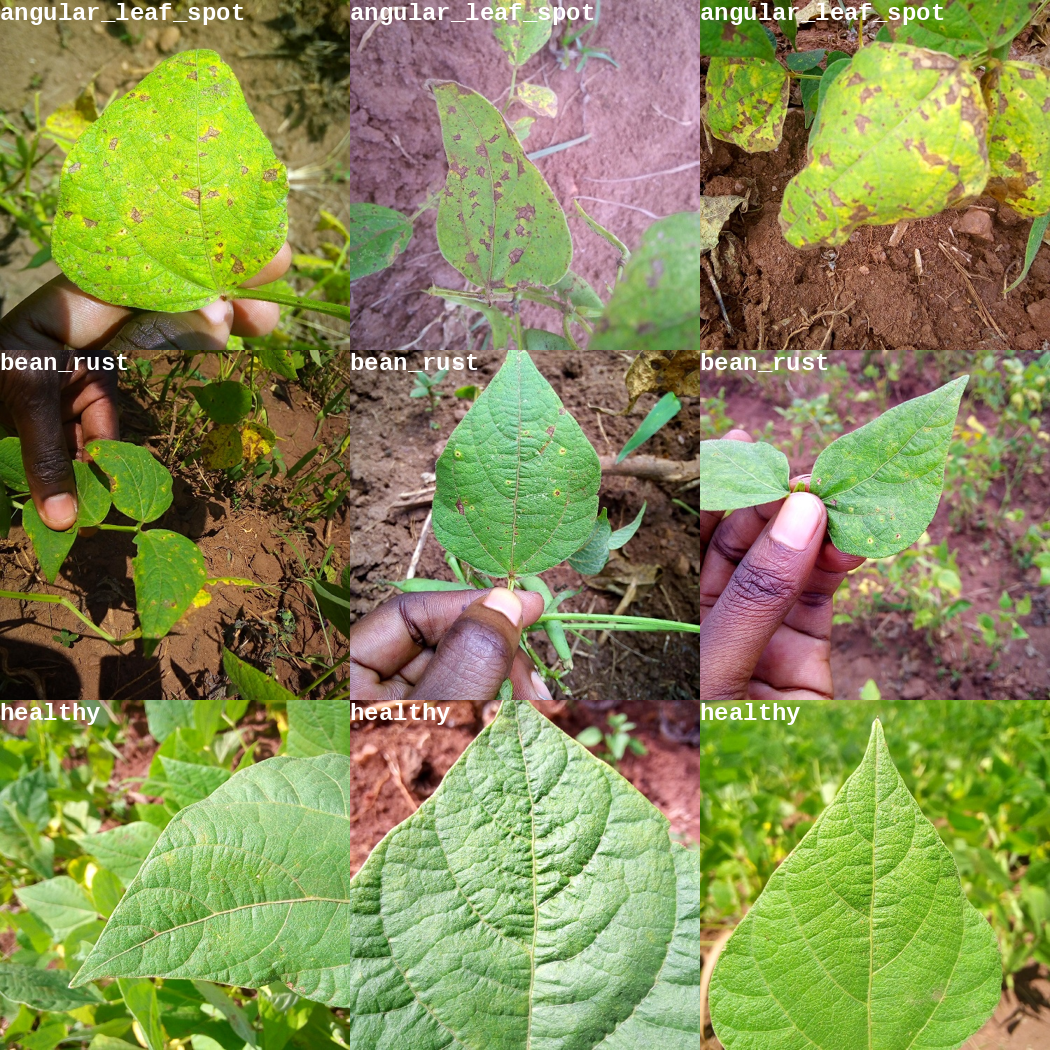

In [14]:
show_examples(ds, seed = random.randint(0, 1337), examples_per_class = 3)

In [15]:
prepared_ds = ds.with_transform(transform)

### 5. Load model and processor

In [16]:
model_name_or_path = 'google/vit-base-patch16-224-in21k'

In [17]:
processor = ViTImageProcessor.from_pretrained(model_name_or_path)

In [18]:
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels = len(labels),
    id2label = {str(i): c for i, c in enumerate(labels)},
    label2id = {c: str(i) for i, c in enumerate(labels)}
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 6. Training

In [19]:
num_epochs = 10

In [20]:
training_args = TrainingArguments(
  output_dir = "./vit-base-beans",
  per_device_train_batch_size = 16,
  num_train_epochs = num_epochs,
  fp16 = True,
  save_steps = 0,
  evaluation_strategy = "epoch",
  logging_steps = 25,
  learning_rate = 2e-5,
  remove_unused_columns = False,
  push_to_hub = False,
  report_to = 'tensorboard'
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [21]:
trainer = Trainer(
    model = model,
    args = training_args,
    data_collator = collate_fn,
    train_dataset = prepared_ds["train"],
    eval_dataset = prepared_ds["validation"],
    tokenizer = processor,
)

In [22]:
train_results = trainer.train()

Epoch,Training Loss,Validation Loss
1,0.600200,0.324889
2,0.176600,0.133137
3,0.095800,0.098896
4,0.055700,0.070417
5,0.042100,0.056401
6,0.037800,0.051700
7,0.033900,0.047354
8,0.031500,0.044767
9,0.030300,0.043568
10,0.029500,0.043192


### 7. Performance

In [23]:
ds_train = ds['train']
ds_val = ds['validation']
ds_test = ds['test']

**a. Train**

In [24]:
y_train = []
y_pred_train = []

for i in range(len(ds_train)):

  inputs = processor(ds_train[i]['image'], return_tensors = 'pt')
  inputs = inputs.to('cuda')
  outputs = model(**inputs)
  pred_idx = int(outputs['logits'].argmax())

  y_pred_train.append(pred_idx)

  real = int(ds_train[i]['labels'])

  y_train.append(real)

y_pred_train = np.array(y_pred_train)
y_train = np.array(y_train)

In [25]:
round(((y_train == y_pred_train)*1).mean()*100, 2)

100.0

**b. Val**

In [26]:
y_val = []
y_pred_val = []

for i in range(len(ds_val)):

  inputs = processor(ds_val[i]['image'], return_tensors = 'pt')
  inputs = inputs.to('cuda')
  outputs = model(**inputs)
  pred_idx = int(outputs['logits'].argmax())

  y_pred_val.append(pred_idx)

  real = int(ds_val[i]['labels'])

  y_val.append(real)

y_pred_val = np.array(y_pred_val)
y_val = np.array(y_val)

In [27]:
round(((y_val == y_pred_val)*1).mean()*100, 2)

100.0

**c. Test**

In [28]:
y_test = []
y_pred_test = []

for i in range(len(ds_test)):

  inputs = processor(ds_test[i]['image'], return_tensors = 'pt')
  inputs = inputs.to('cuda')
  outputs = model(**inputs)
  pred_idx = int(outputs['logits'].argmax())

  y_pred_test.append(pred_idx)

  real = int(ds_test[i]['labels'])

  y_test.append(real)

y_pred_test = np.array(y_pred_test)
y_test = np.array(y_test)

In [29]:
round(((y_test == y_pred_test)*1).mean()*100, 2)

95.31

### End of execution

In [30]:
end = time.time()

delta = (end - start)

hours = int(delta/3_600)
mins = int((delta - hours*3_600)/60)
secs = int(delta - hours*3_600 - mins*60)

print(f'Hours: {hours}, Minutes: {mins}, Seconds: {secs}')

Hours: 0, Minutes: 3, Seconds: 15
